## Handwriting: OCR

Dataset Source: https://www.kaggle.com/datasets/ssarkar445/handwriting-recognitionocr

##### Install Necessary Libraries

In [1]:
%pip install torch torchvision pandas sklearn transformers evaluate

Note: you may need to restart the kernel to use updated packages.


##### Import Necessary Libraries

In [2]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


##### Display Versions of Relevant Software & Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
        Pandas: 1.5.0
  Transformers: 4.26.1
         Torch: 1.12.1


### Determine Appropriate Max Length of Text

#### Create DataFrame of All Three Datasets Combined

In [4]:
parent_dir = "/Users/briandunn/Documents/OCR/Handwriting Recognition"

train_dataset = pd.read_csv(os.path.join(parent_dir, "CSV/written_name_train.csv"))
test_dataset = pd.read_csv(os.path.join(parent_dir, "CSV/written_name_test.csv"))
eval_dataset = pd.read_csv(os.path.join(parent_dir, "CSV/written_name_validation.csv"))

# Combine all three dataframes
dataset = pd.concat([train_dataset, test_dataset, eval_dataset])
dataset.rename(columns={"FILENAME" : "file_name", "IDENTITY" : "text"}, inplace=True)
dataset = dataset.dropna()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412988 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   file_name  412988 non-null  object
 1   text       412988 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


#### Visualize: Histogram of Text Lengths

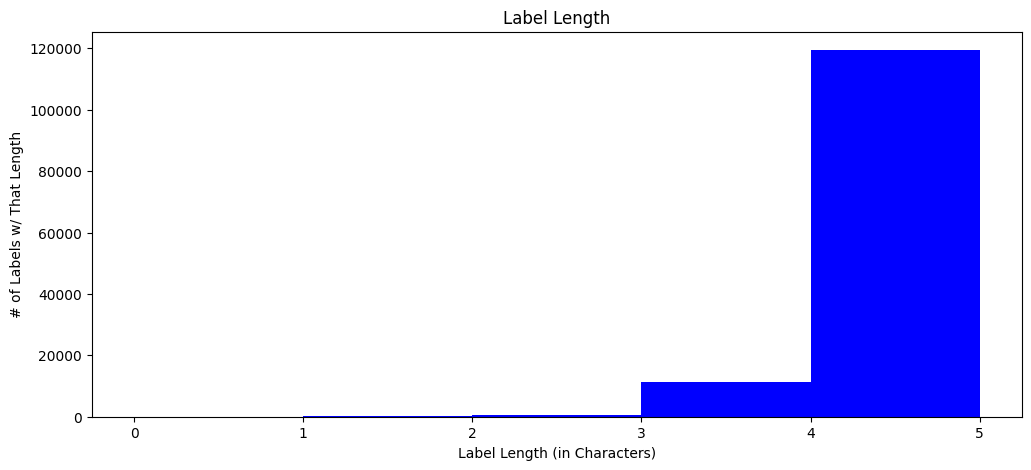

In [5]:
dataset['label_len'] = dataset['text'].str.len()

max_length_value = 5
dataset.hist("label_len", 
             grid=False, 
             color="Blue", 
             figsize=(12,5), 
             bins=max_length_value, 
             range=(0, max_length_value)
             )

plt.suptitle('')
plt.xlabel('Label Length (in Characters)')
plt.ylabel('# of Labels w/ That Length')
plt.title('Label Length')
plt.show()

### Prepare Data For Model

#### Ingest & Preprocess Training Dataset

In [6]:
train_dataset = pd.read_csv(os.path.join(parent_dir, "CSV/written_name_train.csv"))
train_dataset.rename(columns={"FILENAME" : "file_name", "IDENTITY" : "text"}, inplace=True)
train_dataset = train_dataset.dropna()

# Filter dataframe so only samples within text character length remain
train_dataset = train_dataset[train_dataset['text'].str.len() <= max_length_value]

# Randomly sample 12.5% of filtered dataset
train_dataset = train_dataset.sample(frac=0.125, replace=False, random_state=42, ignore_index=True)

train_dataset

,file_name,text
0,TRAIN_297469.jpg,EMMA
1,TRAIN_67579.jpg,CARLA
2,TRAIN_04323.jpg,RIAHI
3,TRAIN_56817.jpg,CASSE
4,TRAIN_70251.jpg,ADAM
...,...,...
13159,TRAIN_197277.jpg,NINA
13160,TRAIN_154076.jpg,CLARA
13161,TRAIN_60123.jpg,LEA
13162,TRAIN_263760.jpg,EMPTY


#### Ingest & Preprocess Testing Dataset

In [7]:
test_dataset = pd.read_csv(os.path.join(parent_dir, "CSV/written_name_test.csv"))
test_dataset.rename(columns={"FILENAME" : "file_name", "IDENTITY" : "text"}, inplace=True)
test_dataset = test_dataset.dropna()

# Filter dataframe so only samples within text character length remain
test_dataset = test_dataset[test_dataset['text'].str.len() <= max_length_value]

# Randomly sample 12.5% of filtered dataset
test_dataset = test_dataset.sample(frac=0.125, replace=False, random_state=42, ignore_index=True)

test_dataset

,file_name,text
0,TEST_9617.jpg,BOYE
1,TEST_15504.jpg,MANZI
2,TEST_30065.jpg,NILS
3,TEST_2848.jpg,ELJAI
4,TEST_24129.jpg,YANA
...,...,...
1646,TEST_22759.jpg,DAVID
1647,TEST_31760.jpg,CLARA
1648,TEST_34704.jpg,PAUL
1649,TEST_5030.jpg,LEO


#### Ingest & Preprocess Validation Dataset

In [8]:
eval_dataset = pd.read_csv(os.path.join(parent_dir, "CSV/written_name_validation.csv"))
eval_dataset.rename(columns={"FILENAME" : "file_name", "IDENTITY" : "text"}, inplace=True)
eval_dataset = eval_dataset.dropna()

# Filter dataframe so only samples within text character length remain
eval_dataset = eval_dataset[eval_dataset['text'].str.len() <= max_length_value]

# Randomly sample 12.5% of filtered dataset
eval_dataset = eval_dataset.sample(frac=0.125, replace=False, random_state=42, ignore_index=True)

eval_dataset

,file_name,text
0,VALIDATION_27302.jpg,RAMET
1,VALIDATION_11864.jpg,OSCAR
2,VALIDATION_36304.jpg,ADAM
3,VALIDATION_38677.jpg,LOUIS
4,VALIDATION_15769.jpg,DIANE
...,...,...
1619,VALIDATION_34508.jpg,RYH
1620,VALIDATION_16793.jpg,DIGET
1621,VALIDATION_24781.jpg,MATIS
1622,VALIDATION_8032.jpg,BOMY


##### Create Dataset Class

In [9]:
class Handwriting_Recognition_OCR_Dataset(Dataset):
    
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id 
                  else -100 for label in labels]
        
        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

##### Basic Values/Constants

In [10]:
MODEL_CKPT = "microsoft/trocr-base-handwritten"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "-OCR-handwriting_recognition"
NUM_OF_EPOCHS = 1

##### Instantiate Processor, Create Training, & Testing Dataset Instances

In [11]:
image_processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = Handwriting_Recognition_OCR_Dataset(root_dir=os.path.join(parent_dir, "train/"),
                             df=train_dataset,
                             processor=image_processor)

test_ds = Handwriting_Recognition_OCR_Dataset(root_dir=os.path.join(parent_dir, "test/"),
                             df=test_dataset,
                             processor=image_processor)

eval_ds = Handwriting_Recognition_OCR_Dataset(root_dir=os.path.join(parent_dir, "validation/"),
                             df=eval_dataset,
                             processor=image_processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


##### Print Length of Training & Testing Datasets

In [12]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")
print(f"The testing dataset has {len(eval_ds)} samples in it.")

The training dataset has 13164 samples in it.
The testing dataset has 1651 samples in it.
The testing dataset has 1624 samples in it.


##### Example of Input Data Shapes

In [13]:
encoding = train_ds[10]

for k,v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([128])


##### Show Example

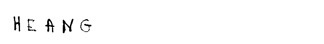

In [14]:
image = Image.open(train_ds.root_dir + train_dataset['file_name'][10]).convert("RGB")

image

##### Show Label for Above Example

In [15]:
labels = encoding['labels']
labels[labels == -100] = image_processor.tokenizer.pad_token_id
label_str = image_processor.decode(labels, skip_special_tokens=True)
print(label_str)

HEANG


#### Instantiate Model

In [16]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Model Configuration Modifications

In [17]:
model.config.decoder_start_token_id = image_processor.tokenizer.cls_token_id
model.config.pad_token_id = image_processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = image_processor.tokenizer.sep_token_id
model.config.max_length = max_length_value
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

print(model.config.max_length)

5


##### Define Metrics Evaluation

In [18]:
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = image_processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = image_processor.tokenizer.pad_token_id
    label_str = image_processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"cer" : cer}

##### Define Training Arguments

In [19]:
args = Seq2SeqTrainingArguments(
    output_dir = MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_first_step=True,
    hub_private_repo=True,
    push_to_hub=True
)

##### Define Trainer

In [20]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition into local empty directory.


##### Fit/Train Model

In [21]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13164
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1646
  Number of trainable parameters = 333921792


A Jupyter Widget

{'loss': 11.0042, 'learning_rate': 4.996962332928311e-05, 'epoch': 0.0}
{'loss': 0.7617, 'learning_rate': 3.481166464155529e-05, 'epoch': 0.3}
{'loss': 0.4115, 'learning_rate': 1.9623329283110573e-05, 'epoch': 0.61}
{'loss': 0.2614, 'learning_rate': 4.434993924665857e-06, 'epoch': 0.91}


***** Running Evaluation *****
  Num examples = 1651
  Batch size = 8
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


A Jupyter Widget

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_

{'eval_loss': 0.2400525063276291, 'eval_cer': 0.05333870751041247, 'eval_runtime': 27317.4945, 'eval_samples_per_second': 0.06, 'eval_steps_per_second': 0.008, 'epoch': 1.0}


Model weights saved in trocr-base-handwritten-OCR-handwriting_recognition/checkpoint-1646/pytorch_model.bin
Image processor saved in trocr-base-handwritten-OCR-handwriting_recognition/checkpoint-1646/preprocessor_config.json
Image processor saved in trocr-base-handwritten-OCR-handwriting_recognition/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 229769.6617, 'train_samples_per_second': 0.057, 'train_steps_per_second': 0.007, 'train_loss': 0.46056485958261595, 'epoch': 1.0}


##### Save Model & Training Metrics

In [22]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to trocr-base-handwritten-OCR-handwriting_recognition
Configuration saved in trocr-base-handwritten-OCR-handwriting_recognition/config.json
Configuration saved in trocr-base-handwritten-OCR-handwriting_recognition/generation_config.json
Model weights saved in trocr-base-handwritten-OCR-handwriting_recognition/pytorch_model.bin
Image processor saved in trocr-base-handwritten-OCR-handwriting_recognition/preprocessor_config.json
Saving model checkpoint to trocr-base-handwritten-OCR-handwriting_recognition
Configuration saved in trocr-base-handwritten-OCR-handwriting_recognition/config.json
Configuration saved in trocr-base-handwritten-OCR-handwriting_recognition/generation_config.json
Model weights saved in trocr-base-handwritten-OCR-handwriting_recognition/pytorch_model.bin
Image processor saved in trocr-base-handwritten-OCR-handwriting_recognition/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition
   593b93c..7250dd1  main -> main

To https://huggingface.co/DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition
   7250dd1..ef8275c  main -> main



***** train metrics *****
  epoch                    =                 1.0
  train_loss               =              0.4606
  train_runtime            = 2 days, 15:49:29.66
  train_samples_per_second =               0.057
  train_steps_per_second   =               0.007


##### Evaluate Model

In [23]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 1651
  Batch size = 8
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}



A Jupyter Widget

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 5,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_

***** eval metrics *****
  epoch                   =        1.0
  eval_cer                =     0.0533
  eval_loss               =     0.2401
  eval_runtime            = 7:39:25.83
  eval_samples_per_second =       0.06
  eval_steps_per_second   =      0.008


##### Push Model to Hub (My Profile!!!)

In [24]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-to-text",
    "tags" : ["image-to-text"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to trocr-base-handwritten-OCR-handwriting_recognition
Configuration saved in trocr-base-handwritten-OCR-handwriting_recognition/config.json
Configuration saved in trocr-base-handwritten-OCR-handwriting_recognition/generation_config.json
Model weights saved in trocr-base-handwritten-OCR-handwriting_recognition/pytorch_model.bin
Image processor saved in trocr-base-handwritten-OCR-handwriting_recognition/preprocessor_config.json


A Jupyter Widget

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/trocr-base-handwritten-OCR-handwriting_recognition
   ef8275c..9b59152  main -> main



### Notes & Other Takeaways From This Project
****
- Unfortunately, I had to reduce the sample size for this project to make it feasible to run. If I had kept it as it was, it would have taken about two months per epoch. Yikes! 
- A Character Error Rate (CER) of 0.0533 is pretty good for the limited training sample size.
****

### Citations

##### For Transformer Checkpoint
- @misc{li2021trocr,
      title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, 
      author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei},
      year={2021},
      eprint={2109.10282},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

##### For CER Metric
- @inproceedings{morris2004,
author = {Morris, Andrew and Maier, Viktoria and Green, Phil},
year = {2004},
month = {01},
pages = {},
title = {From WER and RIL to MER and WIL: improved evaluation measures for connected speech recognition.}
}